# PROACT Dataset

In [1]:
import config as cfg
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from utility.survival import make_time_bins
from SurvivalEVAL.Evaluations.util import KaplanMeier

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

from utility.plot import load_tf_color
TFColor = load_tf_color()

df = pd.read_csv(Path.joinpath(cfg.PROACT_DATA_DIR, 'proact_processed.csv'), index_col=0)
df = df.loc[(df['TTE_Bulbar'] > 0) & (df['TTE_FineMotor'] > 0)
            & (df['TTE_GrossMotor'] > 0) & (df['TTE_Breathing'] > 0)] # min time
df = df.loc[(df['TTE_Bulbar'] <= 1000) & (df['TTE_FineMotor'] <= 1000)
            & (df['TTE_GrossMotor'] <= 1000) & (df['TTE_Breathing'] <= 1000)] # 5 years max

c:\Users\cml\miniconda3\envs\py39-als\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Print statistics on people that don't experience death event
df['Time_in_study'] = df.apply(lambda x: max(x['TTE_Bulbar'],  x['TTE_FineMotor'],
                                             x['TTE_GrossMotor'], x['TTE_Breathing']), axis=1)
df['SOO_Limb'] = df['Site_of_Onset'].apply(lambda x: 1 if x in ["Limb", "LimbAndBulbar"] else 0)
df['SOO_Bulbar'] = df['Site_of_Onset'].apply(lambda x: 1 if x in ["Bulbar", "LimbAndBulbar"] else 0)
df['SOO_Other'] = df['Site_of_Onset'].apply(lambda x: 1 if x in ["Other"] else 0)

num_features = ['Age', 'Height', 'Weight', 'ALSFRS_R_Total', 'Time_in_study']
cat_features = ['Sex', 'Race_Caucasian', 'SOO_Limb', 'SOO_Bulbar', 'SOO_Spine', 'Subject_used_Riluzole']
df_no_deaths = df.loc[df['Death'] == 0]
df_deaths = df.loc[df['Death'] == 1]
 
print(f'N no_deaths: {df_no_deaths.shape[0]} - N deaths: {df_deaths.shape[0]}')

for col in num_features:
    mean_no_deaths = df_no_deaths[col].astype(float).mean(axis=0).round(1)
    mean_deaths = df_deaths[col].astype(float).mean(axis=0).round(1)
    std_no_deaths = df_no_deaths[col].astype(float).std(axis=0).round(1)
    std_deaths = df_deaths[col].astype(float).std(axis=0).round(1)
    
    text_no_deaths = mean_no_deaths.astype(str) + " (" + std_no_deaths.astype(str) + ")"
    text_deaths = mean_deaths.astype(str) + " (" + std_deaths.astype(str) + ")"
    print(f"{col} (event): {text_no_deaths} - {col} (death): {text_deaths}")

print()
for data in [df_no_deaths, df_deaths]:
    print(f"Percentage of female: {data['Sex'].value_counts(normalize=True)['Female'] * 100:.1f}%")
    print(f"Percentage of Caucasian: {data['Race_Caucasian'].value_counts(normalize=True)[1.0] * 100:.1f}%")
    print(f"Percentage of SOO_Limb: {data['SOO_Limb'].value_counts(normalize=True)[1] * 100:.1f}%")
    print(f"Percentage of SOO_Bulbar: {data['SOO_Bulbar'].value_counts(normalize=True)[1] * 100:.1f}%")
    print(f"Percentage of SOO_Other: {data['SOO_Other'].value_counts(normalize=True)[1] * 100:.1f}%")
    print(f"Percentage of Subject_used_Riluzole: {data['Subject_used_Riluzole'].value_counts(normalize=True)['Yes'] * 100:.1f}%")
    print()

In [22]:
# Load data for modeling
df = pd.read_csv(Path.joinpath(cfg.PROACT_DATA_DIR, 'proact_processed.csv'), index_col=0)
df = df.loc[(df['TTE_Bulbar'] > 0) & (df['TTE_FineMotor'] > 0)
            & (df['TTE_GrossMotor'] > 0) & (df['TTE_Breathing'] > 0)] # min time
df = df.loc[(df['TTE_Bulbar'] <= 1000) & (df['TTE_FineMotor'] <= 1000)
            & (df['TTE_GrossMotor'] <= 1000) & (df['TTE_Breathing'] <= 1000)]
df = df.dropna(subset='Handgrip_Strength') # drop rows with no handgrip test
df['El_escorial'] = df['El_escorial'].replace('Possible', 'Probable') # Replace "Possible" with "Probable"
df = df.drop('Race_Caucasian', axis=1) # Drop race information
df = df.drop('El_escorial', axis=1) # Drop el_escorial
df = df.drop(['Height', 'Weight'], axis=1) # drop height/weight
df = df.drop(columns=['ABDUCTOR_POLLICIS_BREVIS_Strength', 
                        'SHOULDER_Strength', 
                        'FIRST_DORSAL_INTEROSSEOUS_OF_THE_HAND_Strength'], axis=1) # drop rare strength tests
event_cols = ['Bulbar', 'FineMotor', 'GrossMotor', 'Breathing']

# Print event distribution ['Speech', 'Swallowing', 'Handwriting', 'Walking']
for event_col in event_cols:
    obs_arr = np.array(df[f"Event_{event_col}"])
    n_censored = obs_arr.shape[0] - obs_arr.sum()
    print(f"Number of samples: {len(df)}")
    print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
    print(f"{round(n_censored / obs_arr.shape[0] * 100, 2)}% of records are censored\n")

Number of samples: 1189
Number of censored/uncensored: 1008/181
84.78% of records are censored

Number of samples: 1189
Number of censored/uncensored: 819/370
68.88% of records are censored

Number of samples: 1189
Number of censored/uncensored: 699/490
58.79% of records are censored

Number of samples: 1189
Number of censored/uncensored: 1063/126
89.4% of records are censored



In [19]:
df

,Diagnosis_Delta,TTE_Bulbar,Event_Bulbar,TTE_FineMotor,Event_FineMotor,TTE_GrossMotor,Event_GrossMotor,TTE_Breathing,Event_Breathing,ALSFRS_R_Total,...,TTE_Death,FVC_Min,FVC_Max,FVC_Mean,Handgrip_Strength,ANKLE_Strength,ELBOW_Strength,HIP_FLEXOR_Strength,KNEE_Strength,WRIST_Strength
2,342.0,713.0,False,713.0,False,254.0,False,713.0,False,45.0,...,713.0,3.78,3.94,3.836667,34.0,6.150,24.150000,22.50,20.200,12.50
5,298.0,171.0,False,80.0,True,171.0,False,92.0,False,34.0,...,171.0,NaN,NaN,NaN,26.5,NaN,NaN,NaN,NaN,NaN
7,226.0,7.0,False,414.0,False,302.0,False,414.0,False,39.0,...,414.0,NaN,NaN,NaN,75.5,NaN,NaN,NaN,NaN,NaN
9,193.0,30.0,True,116.0,True,51.0,True,188.0,True,36.0,...,188.0,2.21,2.80,2.596667,40.0,1.000,21.791667,NaN,0.000,17.00
14,113.0,126.0,False,126.0,False,82.0,True,126.0,False,38.0,...,126.0,NaN,NaN,NaN,88.7,12.540,45.375000,34.45,38.120,29.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5868,93.0,137.0,False,137.0,False,52.0,False,376.0,False,33.0,...,665.0,0.03,4.40,2.926667,58.0,45.750,34.250000,42.00,29.430,14.60
5888,86.0,61.0,False,61.0,False,48.0,True,61.0,False,30.0,...,545.0,2.70,2.90,2.786667,46.0,NaN,22.125000,NaN,NaN,18.25
5889,86.0,61.0,False,61.0,False,48.0,True,61.0,False,30.0,...,545.0,2.70,2.90,2.786667,46.0,NaN,22.125000,NaN,NaN,18.25
5892,20.0,382.0,False,382.0,False,306.0,False,382.0,False,44.0,...,382.0,2.66,2.84,2.733333,12.0,4.725,29.600000,24.80,30.125,26.75


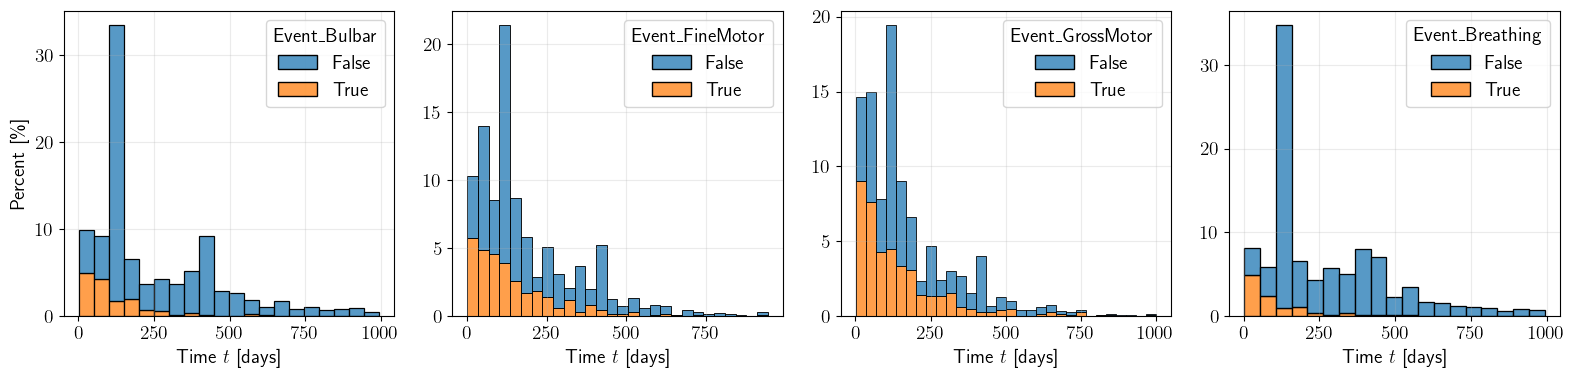

In [21]:
# Plot event distribution
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))  # Adjust the figure width for 4 plots
axs = axs.flatten()
for i, col in enumerate(event_cols):
    event = df[[f'TTE_{col}', f'Event_{col}']]  # Assuming 'df' is defined elsewhere
    sns.histplot(x=f'TTE_{col}', data=event, hue=f'Event_{col}', multiple="stack", bins="auto", ax=axs[i], stat="percent")
    axs[i].set_xlabel("Time $t$ [days]")
    if i == 0:
        axs[i].set_ylabel("Percent [\%]")
    else:
        axs[i].set_ylabel("")
    axs[i].grid(True, alpha=0.25)
plt.tight_layout()
#fg.PLOTS_DIR}/proact_event_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [56]:
# Print event distribution ['Bulbar', 'FineMotor', 'GrossMotor', 'Breathing']
for event_col in event_cols:
    obs_arr = np.array(df[event_col])
    n_censored = obs_arr.shape[0] - obs_arr.sum()
    print(f"Number of samples: {len(df)}")
    print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
    print(f"{round(n_censored / obs_arr.shape[0] * 100, 2)}% of records are censored\n")

Number of samples: 1189
Number of censored/uncensored: 1012/177
85.11% of records are censored

Number of samples: 1189
Number of censored/uncensored: 824/365
69.3% of records are censored

Number of samples: 1189
Number of censored/uncensored: 699/490
58.79% of records are censored

Number of samples: 1189
Number of censored/uncensored: 1068/121
89.82% of records are censored



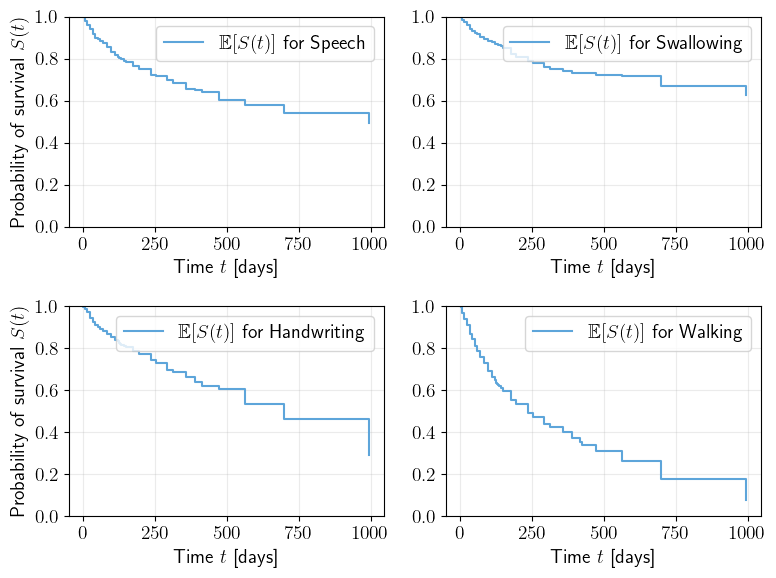

In [14]:
# Plot KM curves
event_times = df[['TTE_Speech', 'TTE_Swallowing', 'TTE_Handwriting', 'TTE_Walking']].to_numpy()
event_indicators = df[['Speech', 'Swallowing', 'Handwriting', 'Walking']].to_numpy()

time_bins = make_time_bins(event_times, event=None)
time_bins = torch.cat((torch.tensor([0]), time_bins))

# Initialize subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for event_id in range(4): # 4 events
    times = event_times[:, event_id]
    indicators = event_indicators[:, event_id]
    
    km_model = KaplanMeier(times, indicators)
    km_surv_prob = torch.from_numpy(km_model.predict(time_bins)).numpy()
    
    # Plotting the survival curve
    axes[event_id].step(time_bins.numpy(), km_surv_prob, where='post',
                        label=r"$\mathbb{E}[S(t)]$ for" + f" {event_cols[event_id]}", color=TFColor[3])
    #axes[event_id].set_title(f'KM Curve for {event_cols[event_id]}')
    axes[event_id].set_xlabel("Time $t$ [days]")
    if event_id % 2 == 0:
        axes[event_id].set_ylabel("Probability of survival $S(t)$")
    axes[event_id].set_ylim(0, 1)
    axes[event_id].legend(loc='upper right')
    axes[event_id].grid(True, alpha=0.25)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/proact_km_curves.pdf", format='pdf', bbox_inches='tight')
plt.show()